In [2]:
# import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv('./data cleaning/All_clean_IQR.csv')
# df = df.drop(['face_width_w','face_length_L'],axis=1)
df

X = df.iloc[:, 4:] # Features
y = df.iloc[:,3:4] # Label
print(y)
print(X)

       Label
0       boss
1       boss
2       boss
3       boss
4       boss
...      ...
67303  sport
67304  sport
67305  sport
67306  sport
67307  sport

[67308 rows x 1 columns]
       Eye_R_S_W  Eye_R_B_W  Eye_L_S_W  Eye_L_B_W  Eye_R_H1_W  Eye_R_H2_W  \
0       0.186630   0.223305   0.182876   0.220148    0.013553    0.032178   
1       0.200132   0.244124   0.177286   0.207472    0.015152    0.038025   
2       0.179414   0.210726   0.192387   0.231409    0.019380    0.045778   
3       0.175631   0.208198   0.179902   0.219480    0.024991    0.057128   
4       0.189342   0.230542   0.180274   0.213068    0.008799    0.020458   
...          ...        ...        ...        ...         ...         ...   
67303   0.189668   0.224763   0.198537   0.235773    0.010172    0.024601   
67304   0.194105   0.231643   0.176857   0.212704    0.012763    0.030614   
67305   0.191906   0.226189   0.189833   0.226757    0.013453    0.031954   
67306   0.201010   0.241555   0.181272   0.21593

In [3]:
def corr_feature_detect(data,threshold=0.75): # 特徵值之間相關係數很高(高度相關)
    """ detect highly-correlated features of a Dataframe
    Parameters
    ----------
    data : pd.Dataframe
    threshold : threshold to identify the variable correlated
        
    Returns
    -------
    pairs of correlated variables
    """
    
    corrmat = data.corr()
    corrmat = corrmat.abs().unstack() # absolute value of corr coef
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1] # remove the digonal(對角線 corr=1)
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    grouped_feature_ls = []
    correlated_groups = []
    
    for feature in corrmat.feature1.unique():
        if feature not in grouped_feature_ls:
    
            # find all features correlated to a single feature
            correlated_block = corrmat[corrmat.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(
                correlated_block.feature2.unique()) + [feature]
    
            # append the block of features to the list
            correlated_groups.append(correlated_block)
    return correlated_groups


In [3]:
# 1 高相關 > 低變異
# corr 0.75
corr = corr_feature_detect(X,threshold=0.75)
# print all the correlated feature groups!
a= []
for i in corr:
    print(i,'\n')
    a.append(i['feature2'])
#print(a)
d=[]
for ft in a:
    for i in ft:
        d.append(i)
#print(d)
deletlist = set(d)
deletlist =list(deletlist)
#print(deletlist)
len(deletlist) #102
X_c= X.drop(X[deletlist],axis=1)
#X_c.shape #(66024, 34)


# 低變異方差過濾 0.0005
selector = VarianceThreshold(threshold=0.0005)
X_cv = selector.fit_transform(X_c)  # 方差過濾

#保留特徵名稱
all_name = X_c.columns.values.tolist() 
select_name_index = selector.get_support(indices=True)  # 留下特徵的索引值，list格式
select_name = []
for i in select_name_index:
    select_name.append(all_name[i])

#X_cv.shape(66024, 8)
print(select_name)

# data normalization
data_nor_X = preprocessing.StandardScaler().fit_transform(X_cv)
data_nor_X

#標準化的資料轉成pandas後csv存檔
df_X = pd.DataFrame(data_nor_X)
df_X.columns = select_name
#pd.concat([df_X,y ],axis=1).to_csv('CorrVar_features.csv',index=False) 


         feature1        feature2      corr
0     Eye_dis_S_L     Eye_dis_B_L  0.998830
200   Eye_dis_S_L      Nose_W_S_L  0.962291
210   Eye_dis_S_L      Eye_L_H1_L  0.957629
351   Eye_dis_S_L    Forehead_w_L  0.923808
364   Eye_dis_S_L    face_width_L  0.921114
420   Eye_dis_S_L      Nosehead_L  0.907592
457   Eye_dis_S_L      Nose_W_M_L  0.902374
587   Eye_dis_S_L   face_length_W  0.889079
704   Eye_dis_S_L   Eyebrow_dis_L  0.880560
752   Eye_dis_S_L       Eye_L_B_L  0.875394
761   Eye_dis_S_L       Eye_R_B_L  0.873893
792   Eye_dis_S_L       Eye_L_S_L  0.870992
808   Eye_dis_S_L       Eye_R_S_L  0.868755
923   Eye_dis_S_L     Lip_width_L  0.856989
942   Eye_dis_S_L     Eyebrow_L_L  0.854634
1062  Eye_dis_S_L     Eyebrow_R_L  0.838049
1089  Eye_dis_S_L  Eyebrow_R_H2_W  0.834491
1104  Eye_dis_S_L  Eyebrow_R_H1_W  0.832847
1130  Eye_dis_S_L  Eyebrow_L_H4_W  0.829863
1132  Eye_dis_S_L     face_down_W  0.829146
1147  Eye_dis_S_L  Eyebrow_L_H5_W  0.827686
1306  Eye_dis_S_L   face_middle_

In [ ]:
#2.高相關 > 卡方 (分析特徵用)

X_c.shape #已做完高相關選的 X : X_c

#卡方 (k=20)
selector =  SelectKBest(chi2,k=20)
X_ck = selector.fit_transform(X_c,y)

#保留特徵名稱
all_name = X_c.columns.values.tolist() 
select_name_index2 = selector.get_support(indices=True)  # 留下特徵的索引值，list格式
select_name2 = []
for i in select_name_index2:
    select_name2.append(all_name[i])
select_name2 
# X_ck.shape 
X_ck
# data normalization
data_nor_X = preprocessing.StandardScaler().fit_transform(X_ck)
data_nor_X

df_X2 = pd.DataFrame(data_nor_X,columns=select_name2)
df_X2
#pd.concat([df_X2,y ],axis=1).to_csv('Corr_K_features.csv',index=False) 

In [ ]:
select_name2 

In [ ]:
#3. 低變異> 高相關
# 低變異方差過濾 0.0005
selector = VarianceThreshold(threshold=0.0005)
X_v = selector.fit_transform(X)  
X_v
#保留特徵名稱
all_name = X.columns.values.tolist() 
select_name_index = selector.get_support(indices=True)  # 留下特徵的索引值，list格式
select_name = []
for i in select_name_index:
    select_name.append(all_name[i])
select_name
# print(X_v.shape)  #(66024,38)
X_v = pd.DataFrame(X_v,columns=select_name) #轉pd才能用相關係數判定
# print(X_v)

# corr 0.75
corr = corr_feature_detect(X_v,threshold=0.75)
# print all the correlated feature groups!
a= []
for i in corr:
    print(i,'\n')
    a.append(i['feature2'])
# print(a)
d=[]
for ft in a:
     for i in ft:
            d.append(i)
#print(d)
deletlist = set(d)
deletlist =list(deletlist)
# #print('deletlist:' , deletlist)
# keep = X_vc.columns
# keep = X_v.columns[keep] # keep col names
X_vc= X_v.drop(X_v[deletlist],axis=1)
X_vc.shape #(66024,9)

# data normalization
data_nor_X = preprocessing.StandardScaler().fit_transform(X_vc)
data_nor_X

#標準化的資料轉成pandas後csv存檔
df_X = pd.DataFrame(data_nor_X,columns=X_vc.columns)
#pd.concat([df_X,y ],axis=1).to_csv('VarCorr_features.csv',index=False) 

In [ ]:
#4. 卡方> 高相關
#卡方 k=50
selector =  SelectKBest(chi2,k=50)
X_k = selector.fit_transform(X,y)
#保留特徵名稱
all_name = X.columns.values.tolist() 
select_name_index = selector.get_support(indices=True)  # 留下特徵的索引值，list格式
select_name4 = []
for i in select_name_index:
    select_name4.append(all_name[i])
print(select_name4)

#print(X_k.shape)#(66024, 50)

X_k = pd.DataFrame(X_k,columns=select_name4) #轉pd才能用相關係數判定

# corr 0.75
corr = corr_feature_detect(X_k,threshold=0.75)
# print all the correlated feature groups!
a= []
for i in corr:
    print(i,'\n')
    a.append(i['feature2'])
#print(a)
d=[]
for ft in a:
    for i in ft:
        d.append(i)
#print(d)
deletlist = set(d)
deletlist =list(deletlist)
#print('deletlist:' , deletlist)
# keep = X_kc.columns
X_kc= X_k.drop(X_k[deletlist],axis=1)
X_kc.shape #(66024,12)

# data normalization
data_nor_X = preprocessing.StandardScaler().fit_transform(X_kc)
data_nor_X

#標準化的資料轉成pandas後csv存檔
df_X = pd.DataFrame(data_nor_X, columns=X_kc.columns)

#pd.concat([df_X,y ],axis=1).to_csv('K_Corr_features.csv',index=False) 

In [4]:
#5. 單純高相關過濾

# corr 0.75
corr = corr_feature_detect(X,threshold=0.75)
# print all the correlated feature groups!
a= []
for i in corr:
    print(i,'\n')
    a.append(i['feature2'])
#print(a)
d=[]
for ft in a:
    for i in ft:
        d.append(i)
#print(d)
deletlist = set(d)
deletlist =list(deletlist)
#print('deletlist:' , deletlist)
X_c= X.drop(X[deletlist],axis=1)
X_c.shape #(66024,34)
keep = X_c.columns
# data normalization
data_nor_X = preprocessing.StandardScaler().fit_transform(X_c)
data_nor_X
X_c
pd.concat([X_c,y],axis=1).to_csv('Corr_features.csv',index=False) 
# Stand = preprocessing.StandardScaler()
# data_nor_X=Stand.fit_transform(X_c)

# #標準化的資料轉成pandas後csv存檔
df_X = pd.DataFrame(data_nor_X)
df_X.columns = keep
# pd.concat([df_X,y],axis=1).to_csv('only_Corr_features.csv',index=False) 
len(keep)

         feature1        feature2      corr
0     Eye_dis_S_L     Eye_dis_B_L  0.998830
200   Eye_dis_S_L      Nose_W_S_L  0.962291
210   Eye_dis_S_L      Eye_L_H1_L  0.957629
351   Eye_dis_S_L    Forehead_w_L  0.923808
364   Eye_dis_S_L    face_width_L  0.921114
420   Eye_dis_S_L      Nosehead_L  0.907592
457   Eye_dis_S_L      Nose_W_M_L  0.902374
587   Eye_dis_S_L   face_length_W  0.889079
704   Eye_dis_S_L   Eyebrow_dis_L  0.880560
752   Eye_dis_S_L       Eye_L_B_L  0.875394
761   Eye_dis_S_L       Eye_R_B_L  0.873893
792   Eye_dis_S_L       Eye_L_S_L  0.870992
808   Eye_dis_S_L       Eye_R_S_L  0.868755
923   Eye_dis_S_L     Lip_width_L  0.856989
942   Eye_dis_S_L     Eyebrow_L_L  0.854634
1062  Eye_dis_S_L     Eyebrow_R_L  0.838049
1089  Eye_dis_S_L  Eyebrow_R_H2_W  0.834491
1104  Eye_dis_S_L  Eyebrow_R_H1_W  0.832847
1130  Eye_dis_S_L  Eyebrow_L_H4_W  0.829863
1132  Eye_dis_S_L     face_down_W  0.829146
1147  Eye_dis_S_L  Eyebrow_L_H5_W  0.827686
1306  Eye_dis_S_L   face_middle_

37

In [ ]:
import pickle
with open ("Standard.pickle","wb") as f:
    pickle.dump(Stand,f,protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
len(deletlist)

In [ ]:
a=X.columns.to_list()
len(a)

In [ ]:
b=[]
for i in a:
    if i in deletlist:
        b.append(False)
    else:
        b.append(True)

In [ ]:
b

coefficient of each compoments:
[[ 0.04471232 -0.01409659  0.30368477  0.01098598  0.16263295  0.01653984
   0.01921584  0.19246045  0.29267785  0.27282479 -0.06176686  0.21382584
   0.26513451  0.05107993  0.06176528  0.29159285  0.0276754   0.02450018
  -0.02974806 -0.33826807 -0.21978254 -0.10791532  0.04288305 -0.16946921
  -0.19178601  0.07004768  0.07054302 -0.32185824 -0.13023322 -0.04401473
   0.03623367  0.00395253 -0.03557518 -0.01928294 -0.29831647  0.02432444
  -0.03248581]
 [ 0.13396417  0.18262214  0.14711005  0.25486625  0.21289417  0.1491859
   0.28613756  0.2228435   0.08641102  0.11247115 -0.01979924 -0.09730677
   0.02743257 -0.0312373   0.09933933  0.00047728  0.11817414  0.3006844
   0.27517842  0.11915068  0.22426912  0.3036544   0.1503857   0.16100459
   0.19971248  0.13266791 -0.02129507  0.03055944 -0.09953316 -0.06980119
   0.07488515 -0.08745701  0.15290807 -0.33795296  0.07483678  0.04859643
   0.06012433]]


Text(0, 0.5, 'PCA2')

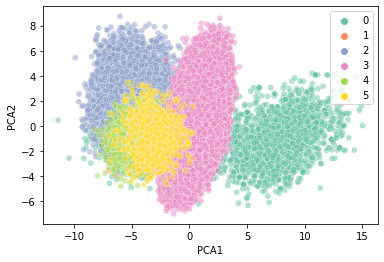

In [6]:
# 特徵 > PCA (2D)
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.colors as mcolors
import seaborn as sns

pca = PCA(n_components=2) # ND -> 2D (Number of components to keep. if n_components is not set all components are kept:)
result = pca.fit_transform(df_X) 
print('coefficient of each compoments:\n{}'.format(pca.components_))
labelencoder = LabelEncoder()
y_data = labelencoder.fit_transform(df['Label'])
# plt.scatter(result[:,0], result[:,1], c=y_data, s=25, alpha=0.4, marker='v')


# plt.xlabel('PCA1')
# plt.ylabel('PCA2')

plt_s = sns.scatterplot(x=result[:,0], 
                y=result[:,1], 
                hue=y_data, 
                style=None, 
                size=None, 
                data=None, 
                palette="Set2", 
                sizes=None, 
                alpha=0.5,
                )
plt_s.set_xlabel("PCA1", fontsize = 10)
plt_s.set_ylabel("PCA2", fontsize = 10)


In [ ]:
df_X2

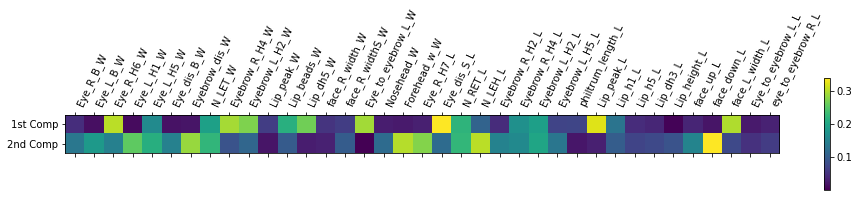

In [7]:
plt.matshow(abs(pca.components_))
plt.yticks([0,1],['1st Comp','2nd Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(df_X.columns)),df_X.columns,rotation=65,ha='left')
plt.show()

C:\Users\Student\anaconda3\envs\ML\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0, 0.5, 'LDA2')

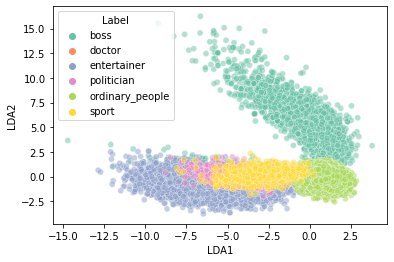

In [116]:
# 特徵篩選 > lDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
lda = LDA(n_components=2) # ND -> 2D (Number of components to keep. if n_components is not set all components are kept:)
result = lda.fit_transform(df_X,y) 
result
#lda.explained_variance_ratio_

#print('coefficient of each compoments:\n{}'.format(lda.explained_variance_))
# labelencoder = LabelEncoder()
# y_data = labelencoder.fit_transform(df['Label'])
# plt.scatter(result[:,0], result[:,1], c=y_data, s=25, alpha=0.4, marker='v')

# plt.xlabel('LDA1')
# plt.ylabel('LDA2')
# label = np.unique(y)
# plt.legend(label[:],loc='upper right')
# plt.show()
import seaborn as sns
plt_s = sns.scatterplot(x=result[:,0], 
                y=result[:,1], 
                hue=(df['Label']), 
                style=None, 
                size=None, 
                data=None, 
                palette="Set2", 
                sizes=None, 
                alpha=0.5,
                )
plt_s.set_xlabel("LDA1", fontsize = 10)
plt_s.set_ylabel("LDA2", fontsize = 10)

In [119]:
lda.scalings_

array([[ 9.78495548e-02, -3.99457488e-01, -3.78186136e-01,
         2.54313358e-01, -4.91354799e-01],
       [-6.30250935e-02, -4.94516172e-01, -6.92230899e-01,
         5.15150569e-01, -3.01576902e-01],
       [-5.93870997e-01,  1.03168943e+00,  5.92779430e-01,
        -3.19110661e-01, -1.20928730e+00],
       [-1.44515246e-01,  7.64236500e-02,  8.96563701e-02,
        -1.40274483e-01, -8.45393398e-02],
       [ 7.51741385e-02,  1.02476324e-01,  5.52607861e-02,
        -2.05361759e-01,  3.16670190e-01],
       [ 2.23462241e+00, -6.26802306e-01,  7.33501599e-01,
        -1.35484510e+00, -1.90062594e+00],
       [-7.35803364e-02,  1.65477297e-02,  2.72023962e-01,
        -2.79380716e-02,  2.52493816e-03],
       [ 7.64735260e-02,  5.51432350e-01,  1.13780696e+00,
        -2.15077033e-01,  6.18115695e-01],
       [-5.80118141e-01, -3.40247253e-01, -1.93876121e-01,
         1.71842779e+00,  3.69517385e-01],
       [-8.57153487e-01,  1.61144650e+00,  6.85437350e-01,
         1.94627666e-01

In [16]:
lda.intercept_

array([ -9.5397088 , -10.72004596, -19.51585817,  -0.56379524,
       -14.02374398, -15.61255471])

In [17]:
dir(lda)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_feature_names',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_max_components',
 '_more_tags',
 '_predict_proba_lr',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_solve_eigen',
 '_solve_lsqr',
 '_solve_svd',
 '_validate_data',
 'classes_',
 'coef_',
 'covariance_estimator',
 'decision_function',
 'explained_variance_ratio_',
 'feature_names_in_',
 'fit',
 'fit_transform',
 'get_params',
 'intercept_',
 'means_',
 'n_components',
 'n_features_in_',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'priors',
 'priors_',
 'scalings_

In [115]:
lda.covariance_estimator

In [114]:
print(lda.covariance_)

AttributeError: 'LinearDiscriminantAnalysis' object has no attribute 'covariance_'

In [102]:
len(lda.coef_[0])

37

In [51]:
lda.coef_[0]
a=list(lda.coef_[0])
a
for i in range(len(a)):
    a[i]=abs(a[i])
a

[1.3680676338247038,
 1.3391004738415755,
 4.174414100572464,
 0.44427170710646824,
 0.19409930721918567,
 5.825114327435962,
 0.10303962623217888,
 1.4292317550858091,
 0.040738458626060736,
 6.528153767200308,
 3.665719590750492,
 1.216555077841497,
 3.939484734135407,
 2.220174911442223,
 0.08246057297529309,
 5.053829475370139,
 0.4583735862681785,
 0.8624510818904737,
 0.1536692273488168,
 11.927387550490424,
 2.0028715762558233,
 0.3984914417896611,
 0.4098180643236259,
 0.4528644968122459,
 5.590532890657572,
 0.49476534093609864,
 0.018374407202152807,
 5.380248829444851,
 0.38957547710939405,
 0.268543513265471,
 2.826278394975687,
 0.5447719160367213,
 0.7212504498771467,
 3.3722878214925287,
 3.740434366901103,
 3.452074714273255,
 0.4200613831721547]

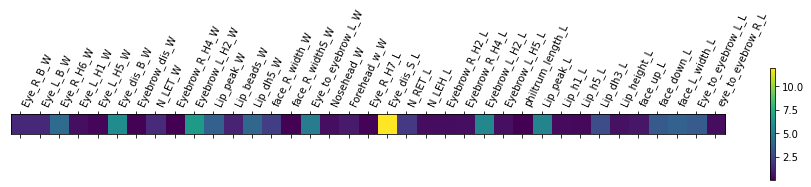

In [101]:
plt.matshow(abs(lda.coef_[0:1]))
plt.yticks([5],['boss'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(df_X.columns)),df_X.columns,rotation=65,ha='left')
plt.show()

In [ ]:
# #T-sne
# from sklearn import datasets
# from sklearn.manifold import TSNE


# tsne = TSNE(n_components=2, random_state=0) # n_components降為幾維
# X_2d = tsne.fit_transform(df_X2)

# print(X_2d.shape)

# # 畫圖需要將Label 轉為數字
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# y_data = labelencoder.fit_transform(df['Label'])
# plt.scatter(X_2d[:,0], X_2d[:,1], c=y_data, s=25, alpha=0.1, marker='o')
# plt.show()

In [ ]:
# corr+K > PCA
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import LabelEncoder
# #抽樣

# df = pd.read_csv('./Corr_K_features.csv')
# import random
# from sklearn.utils import shuffle
# df = shuffle(df)
# df
# filter1=df['Label']=='boss'  #158
# filter2=df['Label']=='sport' #154
# filter3=df['Label']=='entertainer' #165
# filter4=df['Label']=='politician'#162
# filter5=df['Label']=='doctor'#157
# filter6=df['Label']=='ordinary_people'# 165

# sub1=df[filter1].sample(n=None, frac=0.05, replace=False, weights=None, random_state=8)
# sub2=df[filter2]
# sub3=df[filter3].sample(n=None, frac=0.03, replace=False, weights=None, random_state=8)
# sub4=df[filter4].sample(n=None, frac=0.15, replace=False, weights=None, random_state=8)
# sub5=df[filter5].sample(n=None, frac=0.25, replace=False, weights=None, random_state=8)
# sub6=df[filter6].sample(n=None, frac=0.003, replace=False, weights=None, random_state=8)
# df=pd.concat([sub1,sub2,sub3,sub4,sub5,sub6],axis=0)
# df_X2=df.iloc[:,:20]
# df_y=df['Label']


# pca2 = PCA(n_components=2) # ND -> 2D (Number of components to keep. if n_components is not set all components are kept:)
# result = pca2.fit_transform(df_X2) 
# print('coefficient of each compoments:\n{}'.format(pca.components_))
# labelencoder = LabelEncoder()
# y_data = labelencoder.fit_transform(df['Label'])
# plt.scatter(result[:,0], result[:,1], c=y_data, s=25, alpha=0.5, marker='o')

In [ ]:
# pca= PCA(n_components=None)
# result = pca.fit_transform(df_X) 
# print('variance-ratio:',pca.explained_variance_ratio_)

In [ ]:
# #單純高相關 > LDA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# from sklearn.preprocessing import LabelEncoder

# lda = LDA(n_components=2) # ND -> 2D (Number of components to keep. if n_components is not set all components are kept:)
# result = lda.fit_transform(df_X2,df_y) 
# # print('coefficient of each compoments:\n{}'.format(pca.components_))
# labelencoder = LabelEncoder()
# y_data = labelencoder.fit_transform(df['Label'])
# plt.scatter(result[:,0], result[:,1], c=y_data, s=25, alpha=0.6, marker='o')
# plt.xlabel('LDA1')
# plt.ylabel('LDA2')
# label = np.unique(df_y)
# label
# plt.legend(label,loc='upper right')
# plt.tight_layout()
# plt.show()
# label=np.unique(df_y)


In [ ]:
#單純高相關 > LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder

lda = LDA(n_components=2) # ND -> 2D (Number of components to keep. if n_components is not set all components are kept:)
result = lda.fit_transform(df_X,y) 
lda.coef_
# print('coefficient of each compoments:\n{}'.format(lda.components_))
# labelencoder = LabelEncoder()
# y_data = labelencoder.fit_transform(df['Label'])
# plt.scatter(result[:,0], result[:,1], c=y_data, s=25, alpha=0.4, marker='v')
# plt.legend(loc='lower right')

In [ ]:
dir(lda)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

#SVM
X_train, X_test, y_train, y_test = train_test_split(df_X, y_data, test_size=0.3)

# we can change kernel to rbf, poly, linear
model = SVC(kernel='linear', C=0.3) #c =Soft cost 懲罰參數 (p.52) kernal(p.58)
model.fit(X_train, y_train)
#前面PCA已先做過標準化 這裡忽略標準化step
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
num_correct_samples = accuracy_score(y_test, y_pred, normalize=False)
con_matrix = confusion_matrix(y_test, y_pred)

print('number of correct sample: {}'.format(num_correct_samples))
print('accuracy: {}'.format(accuracy))
print('con_matrix: {}'.format(con_matrix))

In [ ]:
from sklearn.pipeline import make_pipeline

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(df_X, y_data)
print(clf.score(X_test, y_test))